# BNN - Comparing to Non-Bayesian Methods for Uncertainty

**Filled notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/Bayesian_Neural_Networks/Complete_DLII_BNN_2_2.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/Bayesian_Neural_Networks/Complete_DLII_BNN_2_2.ipynb)   
**Empty notebook:** 
[![View Empty on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/Bayesian_Neural_Networks/Student_DLII_BNN_2_2.ipynb)
[![Open Empty In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/Bayesian_Neural_Networks/Student_DLII_BNN_2_2.ipynb)   
**Authors:**
Ilze Amanda Auzina, Leonard Bereska and Eric Nalisnick

In this tutorial we will investigate what are some benefits of Bayesian Neural Networks (BNN) over point estimate Neural Networks. 

Import the usual suspects...

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm

torch.manual_seed(81);

### Simulate Data

Let's simulate a wiggly line and draw observations in separated regions...

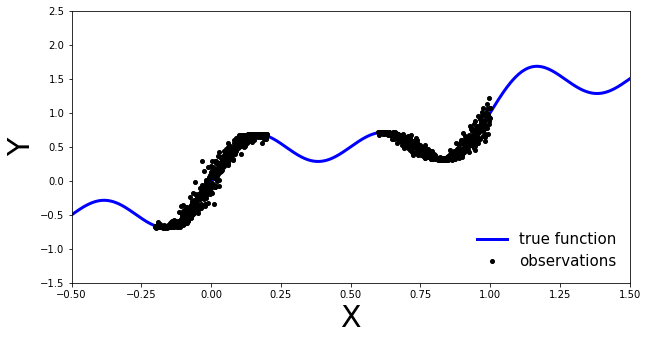

In [ ]:
# set Numpy seed
np.random.seed(42)

# sample observations
x = np.linspace(-.2, 0.2, 500)
x = np.hstack([x, np.linspace(.6, 1, 500)])
ε = 0.02 * np.random.randn(x.shape[0])
y = x + 0.3 * np.sin(2 * np.pi * (x + ε)) + 0.3 * np.sin(4 * np.pi * (x + ε)) + ε

# compute true function
x_true = np.linspace(-.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true) 


# make plot
xlims = [-.5, 1.5]
ylims = [-1.5, 2.5]

fig, ax = plt.subplots(figsize=(10, 5))
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)

ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
ax.plot(x, y, 'ko', markersize=4, label="observations")

plt.legend(loc=4, fontsize=15, frameon=False);

As you can see, we have the true function in blue. The observations are observable in two regions of the function and there is some noise in their measurement. We will use this simple data to showcase the differences between BNN and deterministic NN.

### Define non-Bayesian Neural Network

First let's create our point estimate neural network, in other words a standard fully connected MLP. We will define the number of hidden layers dynamically so we can reuse the same class for different depths.  We will also add two flags, *residual* and *dropout* flag, this will allow us to easily use the same architecture for our BNN. 

In [ ]:
class MLP(nn.Module):
  def __init__(self, in_dim=1, out_dim=1, hid_dim=10, n_hid_layers=1, residual_flag=False, dropout_flag=False, dropout_prob = 0.5):
    super().__init__()
    assert in_dim > 0
    assert out_dim > 0
    assert hid_dim > 0
    assert n_hid_layers > 0
    self.activation = nn.Tanh() # could also be nn.ReLU()
    self.residual_flag = residual_flag
    self.dropout_flag = dropout_flag

    # optional: activate dropout
    self.dropout = nn.Dropout(p=dropout_prob)
        
    # dynamically define architecture
    self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
    layer_list = [nn.Linear(self.layer_sizes[idx-1], self.layer_sizes[idx]) for idx in range(1, len(self.layer_sizes))]
    self.layers = nn.ModuleList(layer_list)
    
  def forward(self, x, y=None):
    #x = x.reshape(-1, 1)
    # input --> hid 
    x = self.activation(self.layers[0](x))
    
    for layer in self.layers[1:-1]:
      # hid --> hid
      x_temp = self.activation(layer(x))

      # optional: compute dropout mask
      if self.dropout_flag:
        x_temp = self.dropout(x_temp)

      # optional: compute residual connection
      if self.residual_flag: 
        x = x_temp + x
      else:
        x = x_temp


    # hid --> output mean
    mu = self.layers[-1](x).squeeze()
    return mu


### Train one deterministic NN

**Training**

Now let's train our MLP with the training data we generated above:

In [ ]:
# define model and data
mlp = MLP(hid_dim=30, n_hid_layers=2, residual_flag=True)
x_train = torch.from_numpy(x).float()[:, None] 
y_train = torch.from_numpy(y).float()

In [ ]:
#select an optimizer and loss function
mlp_optimizer = torch.optim.Adam(params=mlp.parameters(), lr=1e-3)
mlp_criterion = nn.MSELoss()

# training loop
bar = trange(3000)
for epoch in bar:
  mlp_optimizer.zero_grad()
  loss = mlp_criterion(y_train, mlp(x_train))
  bar.set_postfix(loss=f'{loss / x_train.shape[0]:.3f}')
  loss.backward()
  mlp_optimizer.step()

  0%|          | 0/3000 [00:00<?, ?it/s]

**Evaluate**

Let's investigate how our deterministic MLP generalizes over the entire domain of our input variable $x$ (the model was only trained on the observations, now we will also pass in data outside this region)

In [ ]:
# compute predictions everywhere
x_test = torch.linspace(xlims[0], xlims[1], 3000)[:, None] 
y_preds = mlp(x_test).clone().detach().numpy();

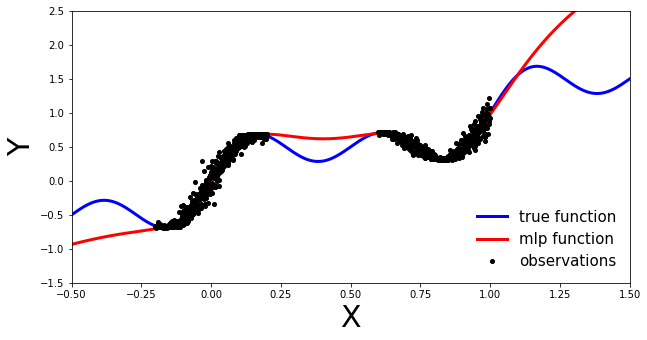

In [ ]:
# generate plot

fig, ax = plt.subplots(figsize=(10, 5))
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)

ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
ax.plot(x_test, y_preds, 'r-', linewidth=3, label="mlp function")
ax.plot(x, y, 'ko', markersize=4, label="observations")

plt.legend(loc=4, fontsize=15, frameon=False);

We can see that our deterministic MLP (red line) has correctly learned the data distribution in the training regions, however, as the model has not learned the underlying sinusoidal wave function, it's predictions outside the training region are inaccurate. As our MLP is a point estimate NN we have no measure confidence in the predictions outside the training region. In the upcoming sections let's see how this compares to BNN.

### Deep Ensemble

Deep ensembles were first introduced by [Lakshminarayanan et al. (2017)](https://arxiv.org/abs/1612.01474). As the name implies multiple point estimate NN are trained, *an ensemble*, and the final prediction is computed as an average across the models. From a Bayesian perspective the different point estimates correspond to modes of a Bayesian posterior. This can be interpreted as approximating the posterior with a distribution parametrized as multiple Dirac deltas:

$$
q_{\phi}(\theta | D) = \sum_{\theta_{i} ∈ ϕ} \alpha_{\theta_{i}} δ_{\theta_{i}}(\theta)
$$
where $\alpha_{\theta_{i}}$ are positive constants such that their sum is equal to one.

**Training**

We will reuse the MLP architecture introduced before, simply now we will train an ensemble of such models

In [ ]:
#define the size of the ensemble: number of NN to train
ensemble_size = 5
ensemble = []
mlp_optimizers = []

# initialize the ensemble
for _ in range(ensemble_size):
    net = MLP(hid_dim=30, n_hid_layers=2, residual_flag=True)
    ensemble.append(net)
    mlp_optimizers.append(torch.optim.Adam(params=net.parameters(), lr=1e-3))

In [ ]:
# train each ensemble component
for idx, net in enumerate(ensemble):

  # training loop for one NN
  bar = trange(3000)
  for epoch in bar:
    mlp_optimizers[idx].zero_grad()
    loss = mlp_criterion(y_train, net(x_train))
    loss.backward()
    mlp_optimizers[idx].step()

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

**Evaluate**

Same as before, let's investigate how our Deep Ensemble performs on the entire data domain of our input variable $x$.

In [ ]:
# compute predictions for each network
y_preds = []
for idx, net in enumerate(ensemble):
  y_preds.append( net(x_test).clone().detach().numpy() )
y_preds = np.array(y_preds)

Plot each ensemble member's predictive function.

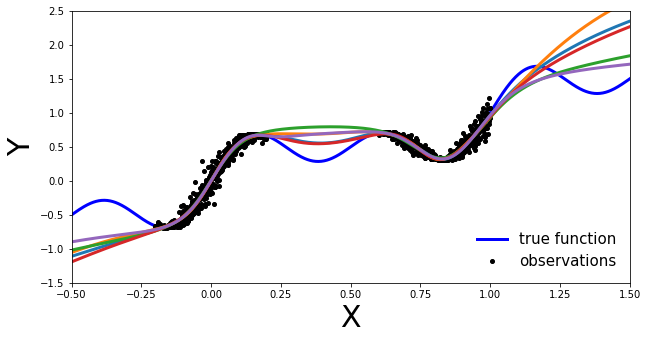

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)

ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
ax.plot(x, y, 'ko', markersize=4, label="observations")

# plot each network's function
for idx in range(ensemble_size):
  ax.plot(x_test, y_preds[idx], '-', linewidth=3)

plt.legend(loc=4, fontsize=15, frameon=False);

In this plot the benefit of an ensemble approach is not immediately clear. Still on the regions outside the training data each of the trained NN is inaccurate. So what is the benefit you might ask. 

Well let's plot the above in a slightly different way: let's visualize the ensemble's **uncertainty bands**.

> From a Bayesian perspective we want to quantity the model's uncertainty on its prediction. This is done via the marginal $p(y|x, D)$, which can be computed as:

$$
p(y|x, D) = \int_{\theta}p(y|x,\theta')p(\theta'|D)d\theta'
$$  

> In practice, for Deep Ensembles we approximate the above by computing the mean and standard deviation across the ensemble. Meaning $p(\theta|D)$ represents the parameters of one of the trained models, $\theta_{i} ∼ p(\theta|D)$, which we then use to compute $y_{i} = f(x,\theta_{i})$, representing $p(y|x,\theta')$.

In [ ]:
# compute mean and standard deviation
y_mean = y_preds.mean(axis=0)
y_std = y_preds.std(axis=0)

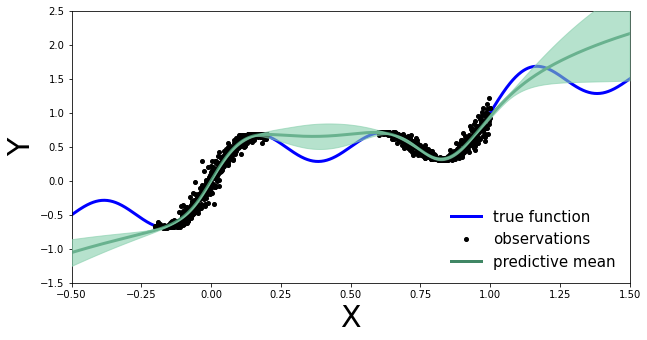

In [ ]:
# generate plot
fig, ax = plt.subplots(figsize=(10, 5))
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)

ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
ax.plot(x, y, 'ko', markersize=4, label="observations")

ax.plot(x_test, y_mean, '-', linewidth=3, color="#408765", label="predictive mean")
ax.fill_between(x_test.ravel(), y_mean - 2 * y_std, y_mean + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

plt.legend(loc=4, fontsize=15, frameon=False);

Now we see the benefit of a Bayesian approach. Outside the training region we not only have the point estimate, but also model's uncertainty about it's predicition.

### Monte Carlo Dropout

First we create our MC-Dropout Network. As you can see in the code below, creating a dropout network is extremely simple:

> we can reuse our existing network architecture, the only alteration is that during the forward pass we randomly *switch off* (zero) some of the elements of the input tensor 

The Bayesian interpretation of MC-Dropout is that we can see each dropout configuration as a different sample from the approximate posterior distribution $\theta_{i} ∼ q(\theta|D)$. 


**Training**

In [ ]:
# define MLP with dropout (probability of 0.5)
dropout_mlp = MLP(hid_dim=30, n_hid_layers=2, residual_flag=True, dropout_flag=True, dropout_prob=0.5)

In [ ]:
# training 
mlp_optimizer = torch.optim.Adam(params=dropout_mlp.parameters(), lr=1e-3)
mlp_criterion = nn.MSELoss()

bar = trange(3000)
for epoch in bar:
  mlp_optimizer.zero_grad()
  loss = mlp_criterion(y_train, dropout_mlp(x_train))
  bar.set_postfix(loss=f'{loss / x_train.shape[0]:.3f}')
  loss.backward()
  mlp_optimizer.step()

  0%|          | 0/3000 [00:00<?, ?it/s]

**Evaluate**

Similarly to Deep Ensembles, we pass the test data multiple times through the MC-Dropout network. We do so to obtain $y_{i}$ at the different parameter settings, $\theta_{i}$ of the network, $y_{i}=f(x,\theta_{i})$, governed by the dropout mask.

>This is the main difference compared to dropout implementation in a deterministic NN where it serves as a regularization term. In normal dropout application during test time the dropout is **not** applied. Meaning that all connections are present, but the weights are [adjusted](https://cs231n.github.io/neural-networks-2/)

In [ ]:
n_mc_samples = 100
y_preds = []

# compute predictions, resampling dropout mask for each forward pass
for idx in range(n_mc_samples):
  y_preds.append(dropout_mlp(x_test).clone().detach().numpy() )
y_preds = np.array(y_preds)

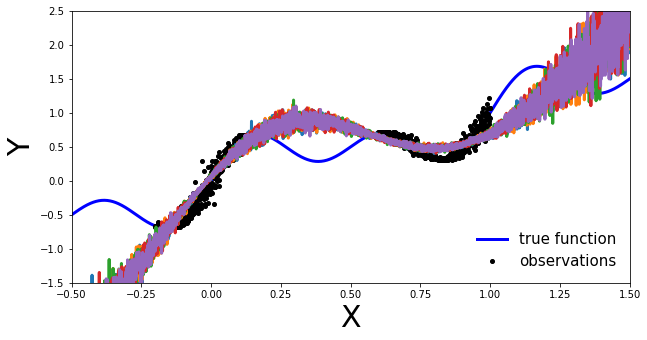

In [ ]:
# generate plot of each dropout (sub)-model
fig, ax = plt.subplots(figsize=(10, 5))
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)

ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
ax.plot(x, y, 'ko', markersize=4, label="observations")

# plot each network's function
for idx in range(ensemble_size):
  ax.plot(x_test, y_preds[idx], '-', linewidth=3)

plt.legend(loc=4, fontsize=15, frameon=False);

In the above plot each colored line (apart from blue) represents a different parametrization, $\theta_{i}$, of our MC-Dropout Network. 

Likewise to the Deep Ensemble Network, we can also compute the MC-dropout's **uncertainty bands**.

> The approach in practice is the same as before: we compute the mean and standard deviation across each dropout mask, which corresponds to the marginal estimation we discussed earlier.

In [ ]:
# compute mean and standard deviation
y_mean = y_preds.mean(axis=0)
y_std = y_preds.std(axis=0)

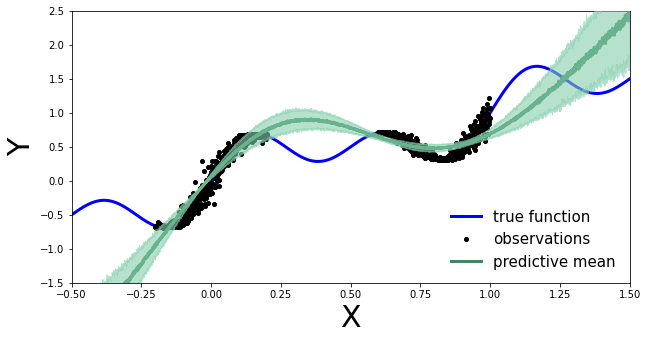

In [ ]:
# generate plot
fig, ax = plt.subplots(figsize=(10, 5))
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)

ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
ax.plot(x, y, 'ko', markersize=4, label="observations")

ax.plot(x_test, y_mean, '-', linewidth=3, color="#408765", label="predictive mean")
ax.fill_between(x_test.ravel(), y_mean - 2 * y_std, y_mean + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

plt.legend(loc=4, fontsize=15, frameon=False);

In the same way as Deep Ensembles, MC-Dropout allows us to have an uncertainty estimate next to our point wise predictions. However, for the given use-case this has come with the cost of an overall drop in the model's performance on the training regions. We observe this because at every pass through our network we randomly choose which nodes to keep, so one could argue that we hinder the networks optimal performance.

## Exercise: Detecting Distribution Shift on MNIST

In this exercise we will compare Bayesian NNs with deterministic NN on distribution shift detection task.  To do this, we'll monitor the predictive entropy as the distribution gradually shifts.  A model with better uncertainty quantification should become less certain---that is, have a more entropic predictive distribuiton---as the input distribution shifts.  Mathematically, our quantity of interest is:
$$ \mathbb{H}[y | x^{*}, D] = - \sum_{y} p(y | x^{*}, D) \log p(y | x^{*}, D)$$ where $p(y | x^{*}, D)$ is the predictive distribuiton: $$ p(y | x^{*}, D) = \int_{\theta} p(y | x^{*}, \theta) \ p(\theta | D) \ d \theta.$$ The goal is to essentially replicate Figure #1 from the paper [Multiplicative Normalizing Flows for Variational Bayesian Neural Networks](https://arxiv.org/abs/1603.04733), comparing MC dropout, ensembles, and a Bayesian NN.  

We will be using the MNIST dataset, a set of 70,000 hand-written digit images, and we will generate a gradual distribution shift on the dataset by rotating the images. As such, the final plot will depict the change in the entropy of the predictive distribution (y-axis) as degree of rotation increases (x-axis). The paper above shows the result for one image.  We, on the other hand, will average over multiple images to make a better comparison between models.

First, let's load MNIST...

In [ ]:
from torchvision import datasets

# download MNIST
mnist_train = datasets.MNIST('../data', train=True, download=True)
mnist_test = datasets.MNIST('../data', train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



Visualize an image...

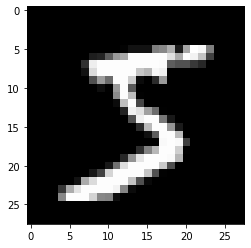

In [ ]:
img_idx = 0
plt.imshow(mnist_train.data[img_idx], cmap='gray', vmin=0, vmax=255);

We'll use rotation to simulate a smooth shift.  Here's how you can rotate a given image...

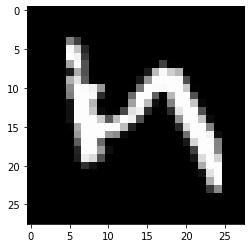

In [ ]:
import torchvision.transforms.functional as TF

rotation_angle = 90
rotated_image = TF.rotate(mnist_train.data[img_idx][None], rotation_angle)[0]

plt.imshow(rotated_image, cmap='gray', vmin=0, vmax=255);

Let's setup the training data...

In [ ]:
x_train = mnist_train.data.reshape(60000, 28*28).float()
y_train = mnist_train.targets

x_test = mnist_test.data.reshape(10000, 28*28).float()
y_test = mnist_test.targets

Now that we have the data, let's start training neural networks.

### Deterministic Network

We will reuse our MLP network architecture but increase the hidden layer dimensionality as well as the number of hidden layers:

In [ ]:
mlp = MLP(in_dim=784, out_dim=10, hid_dim=200, n_hid_layers=3, residual_flag=True, dropout_flag=False)

**Training**

In [ ]:
# training 
mlp_optimizer = torch.optim.Adam(params=mlp.parameters(), lr=1e-4)
mlp_criterion = nn.CrossEntropyLoss()
batch_size = 250

bar = trange(30)
for epoch in bar:
  for batch_idx in range(int(x_train.shape[0] / batch_size)):
    batch_low, batch_high = batch_idx * batch_size, (batch_idx+1) * batch_size
    mlp_optimizer.zero_grad()
    loss = mlp_criterion(target=y_train[batch_low:batch_high], input=mlp(x_train[batch_low:batch_high]))
    bar.set_postfix(loss=f'{loss / batch_size:.3f}') #x.shape[0]
    loss.backward()
    mlp_optimizer.step()

  0%|          | 0/30 [00:00<?, ?it/s]

**Test**

In [ ]:
def accuracy(targets, predictions):
  return (targets == predictions).sum() / targets.shape[0]

In [ ]:
# get test accuracy, to make sure we have a satisfactory model
mlp.eval()
test_preds = mlp(x_test).argmax(1)
acc = accuracy(y_test, test_preds)

print("Test accuracy is %.2f%%" %(acc.item() * 100))

Test accuracy is 96.49%


### Rotating the images

Now let's compute predictive entropy on some rotated images...

First we will generate the rotated images with an increasing rotation angle from the test images:

In [ ]:
# use angles from 0 to 90 degrees
rotation_angles = [3 * i for i in range(0, 31)]
n_test_images = 100

rotated_images = []
for angle in rotation_angles:
  rotated_images.append( TF.rotate(mnist_test.data[:n_test_images].float()[None], angle)[0].reshape(n_test_images, 28*28) )

Evaluate the trained MLP on the rotated images:

In [ ]:
softmax = torch.nn.functional.softmax

In [ ]:
deter_pred_means = []
for image in rotated_images:
  deter_pred_means.append( softmax(mlp(image), dim=1) )

In [ ]:
def entropy(p):
  return (-p * np.log(p)).sum(axis=1)

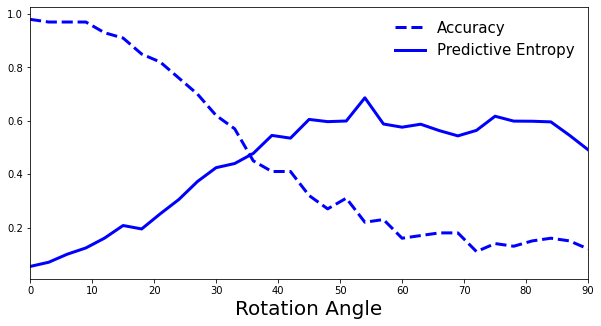

In [ ]:

# generate plot 
fig, ax = plt.subplots(figsize=(10, 5))
plt.xlim([0, 90])
plt.xlabel("Rotation Angle", fontsize=20)

ax.plot(rotation_angles, [accuracy(y_test[:n_test_images], p.argmax(axis=1)) for p in deter_pred_means], 'b--', linewidth=3, label="Accuracy")
ax.plot(rotation_angles, [np.mean(entropy(p.detach().numpy())) for p in deter_pred_means], 'b-', linewidth=3, label="Predictive Entropy")

plt.legend(loc=1, fontsize=15, frameon=False);

In the above plot we can see how well our deterministic MLP performs on the test images as the rotation angle is increased (increasing distribution shift). As expected, with a higher rotation angle model's accuracy drops and its predictive entropy increases, as the network class predictions are more uniformly distributed (recall the predictive entropy equation)

### Monte Carlo Dropout Network

Let's create our Dropout Network. We keep the network depth and hidden layer size the same as for the MLP for a fair model comparison

In [ ]:
dropout_mlp = MLP(in_dim=784, out_dim=10, hid_dim=200, n_hid_layers=3, residual_flag=True, dropout_flag=True)

**Training**

In [ ]:
# training 
mlp_optimizer = torch.optim.Adam(params=dropout_mlp.parameters(), lr=1e-4)
mlp_criterion = nn.CrossEntropyLoss()
batch_size = 250

bar = trange(30)
for epoch in bar:
  for batch_idx in range(int(x_train.shape[0] / batch_size)):
    batch_low, batch_high = batch_idx * batch_size, (batch_idx+1) * batch_size
    mlp_optimizer.zero_grad()
    loss = mlp_criterion(target=y_train[batch_low:batch_high], input=dropout_mlp(x_train[batch_low:batch_high]))
    bar.set_postfix(loss=f'{loss / batch_size:.3f}')
    loss.backward()
    mlp_optimizer.step()

  0%|          | 0/30 [00:00<?, ?it/s]

**Test**

In [ ]:
# get test accuracy
dropout_mlp.eval()
test_preds = dropout_mlp(x_test).argmax(1)
acc = accuracy(y_test, test_preds)

print("Test accuracy is %.2f%%" %(acc.item() * 100))

Test accuracy is 96.57%


**Evaluate on rotated images**

In [ ]:
n_mc_samples = 100
dropout_mlp.train() #we set the model to train so the dropout layer is 'active'

dropout_pred_means = []
for image in rotated_images:
  # compute predictions, resampling dropout mask for each forward pass
  y_preds = torch.zeros((n_test_images, 10))
  for idx in range(n_mc_samples):
    y_preds += softmax(dropout_mlp(image), dim=1)
  dropout_pred_means.append( y_preds / n_mc_samples )

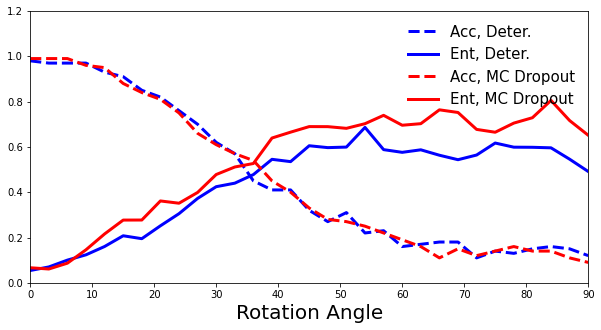

In [ ]:
# generate plot 
fig, ax = plt.subplots(figsize=(10, 5))
plt.xlim([0, 90])
plt.ylim([0, 1.2])
plt.xlabel("Rotation Angle", fontsize=20)

# plot deterministic results
ax.plot(rotation_angles, [accuracy(y_test[:n_test_images], p.argmax(axis=1)) for p in deter_pred_means], 'b--', linewidth=3, label="Acc, Deter.");
ax.plot(rotation_angles, [np.mean(entropy(p.detach().numpy())) for p in deter_pred_means], 'b-', linewidth=3, label="Ent, Deter.");

# plot MC dropout results
ax.plot(rotation_angles, [accuracy(y_test[:n_test_images], p.argmax(axis=1)) for p in dropout_pred_means], 'r--', linewidth=3, label="Acc, MC Dropout")
ax.plot(rotation_angles, [np.mean(entropy(p.detach().numpy())) for p in dropout_pred_means], 'r-', linewidth=3, label="Ent, MC Dropout")

plt.legend(loc=1, fontsize=15, frameon=False);

The accuracy is on par between the MC-Dropout and MLP. However, now we can see that the MC-Dropout has a better uncertainty quantification as it's predictive entropy is higher. What this means is that overall both model prediction uncertainty increases as the distribution shift increases, however, as MC-dropout computes a model average it is more sensitive (more uncertain) about the predictions with a higher rotation angle.

### Deep Ensemble

Now let's investigate Deep Ensemble performance. We will use the exact same network hyperparameters as for the MLP:

In [ ]:
# define the size of the ensemble: number of NN to train
ensemble_size = 5
ensemble = []
mlp_optimizers = []

# initialize the ensemble
for _ in range(ensemble_size):
    net = MLP(in_dim=784, out_dim=10, hid_dim=200, n_hid_layers=3, residual_flag=True, dropout_flag=False)
    ensemble.append(net)
    mlp_optimizers.append(torch.optim.Adam(params=net.parameters(), lr=1e-4))

**Training**

In [ ]:
# train each ensemble component
batch_size = 250
mlp_criterion = nn.CrossEntropyLoss()

for idx, net in enumerate(ensemble):
  # training loop for one NN
  net = ensemble[idx]
  bar = trange(30)
  for epoch in bar:
    for batch_idx in range(int(x_train.shape[0] / batch_size)):
      batch_low, batch_high = batch_idx * batch_size, (batch_idx+1) * batch_size
      mlp_optimizers[idx].zero_grad()
      loss = mlp_criterion(target=y_train[batch_low:batch_high], input=net(x_train[batch_low:batch_high]))
      bar.set_postfix(loss=f'{loss / batch_size:.3f}')
      loss.backward()
      mlp_optimizers[idx].step()


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

**Test**

In [ ]:
# get test accuracy
# compute predictions for each network
test_preds = []
for idx, net in enumerate(ensemble):
  net.eval()
  test_preds.append(net(x_test).argmax(1))

test_preds = torch.stack(test_preds, dim=0)
test_preds = torch.sum(test_preds, dim=0)*1/ensemble_size #we average the predictions over the ensemble

# compute the accuracy
acc = accuracy(y_test, test_preds.int())

print("Test accuracy is %.2f%%" %(acc.item() * 100))

Test accuracy is 93.88%


**Evaluate on rotated images**

In [ ]:
ensemble_pred_means = []
for image in rotated_images:
  # compute predictions for each ensemble network
  y_preds = torch.zeros((n_test_images, 10))
  for idx, net in enumerate(ensemble):
    y_preds += softmax(net(image), dim=1)
  ensemble_pred_means.append( y_preds / ensemble_size )

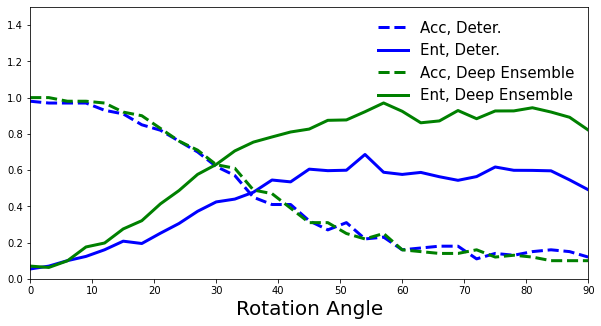

In [ ]:
# generate plot 
fig, ax = plt.subplots(figsize=(10, 5))
plt.xlim([0, 90])
plt.ylim([0, 1.5])
plt.xlabel("Rotation Angle", fontsize=20)

# plot deterministic results
ax.plot(rotation_angles, [accuracy(y_test[:n_test_images], p.argmax(axis=1)) for p in deter_pred_means], 'b--', linewidth=3, label="Acc, Deter.");
ax.plot(rotation_angles, [np.mean(entropy(p.detach().numpy())) for p in deter_pred_means], 'b-', linewidth=3, label="Ent, Deter.");

# plot Ensemble results
ax.plot(rotation_angles, [accuracy(y_test[:n_test_images], p.argmax(axis=1)) for p in ensemble_pred_means], 'g--', linewidth=3, label="Acc, Deep Ensemble")
ax.plot(rotation_angles, [np.mean(entropy(p.detach().numpy())) for p in ensemble_pred_means], 'g-', linewidth=3, label="Ent, Deep Ensemble")

plt.legend(loc=1, fontsize=15, frameon=False);

The accuracy of the Deep Ensemble is initially lower than of our deterministic MLP. However, this is accounted by the fact that the Deep Ensemble is better in uncertainty quantification as it's predictive entropy is higher. How to interpret this? Well, in Deep Ensemble we have trained multiple deterministic MLPs. As the rotation angle increases the point-estimates of each model become more varied, hence the average of these point estimates, $p(y|x^{*},D)$, has a more uniform distribution across the classes. As such, the resulting predictive entorpy is higher, as the log of $p(y|x^{*},D)$ is more negative for smaller values (recall [log function](https://upload.wikimedia.org/wikipedia/commons/8/81/Logarithm_plots.png)). 

### Bayesian Neural Network

We will train a *truly* Bayesian Neural Netowrk with SVI

First, lets install the pyro package:

In [ ]:
!pip install pyro-ppl

     |████████████████████████████████| 718 kB 5.3 MB/s 
     |████████████████████████████████| 750.6 MB 12 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.


In [ ]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import Predictive
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.distributions import Normal, Categorical
from torch.nn.functional import softmax
from tqdm.auto import trange, tqdm

Now let's build our BNN!

As a backbone use the MLP architecture introduced in the beginning of the notebook. However, because we will implement a custom *guide()*, define every layer explicitly.

In [ ]:
class My_MLP(nn.Module):
    
    def __init__(self, in_dim=784, out_dim=10, hid_dim=200):
        super().__init__()
        assert in_dim > 0
        assert out_dim > 0
        assert hid_dim > 0
        self.activation = nn.Tanh() # could also be nn.ReLU()

        #3 hidden layers
        self.fc1 = nn.Linear(in_dim, hid_dim)
        self.fc2 = nn.Linear(hid_dim, hid_dim)
        self.fc3 = nn.Linear(hid_dim, hid_dim)
        self.out = nn.Linear(hid_dim, out_dim)
        
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))

        #hid --> output prob
        yhat = self.out(x).squeeze()
        return yhat

Initialize the network. You will have to access it's layers in your model and guide functions

In [ ]:
net = My_MLP()

In [ ]:
#confirm your layer names
for name, _ in net.named_parameters():
    print(name)

fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias
out.weight
out.bias


Define the model:

> Probabilistic models in Pyro are specified as *model()* functions. This function defines how the output data is generated. Within the model() function, first, the pyro module *random_module()* converts the paramaters of our NN into random variables that have prior probability distributions. Second, in pyro *sample* we define that the output of the network is categorical, while the pyro *plate* allows us to vectorize this function for computational efficiency.

> Hint: remember we are doing a classification instead of regression!


We will 'cheat' a little: to speed up training and limit a bit more the number of paramters we need to optimize, we will implement a BNN where only the **last layer** is Bayesian!

In [ ]:
#if you want to try later a full BNN, you can uncomment the other lines
def model(x_data, y_data):

    #weight and bias priors

    # fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight)).to_event(2)
    # fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias)).to_event(1)

    # fc2w_prior = Normal(loc=torch.zeros_like(net.fc2.weight), scale=torch.ones_like(net.fc2.weight)).to_event(2)
    # fc2b_prior = Normal(loc=torch.zeros_like(net.fc2.bias), scale=torch.ones_like(net.fc2.bias)).to_event(1)

    # fc3w_prior = Normal(loc=torch.zeros_like(net.fc3.weight), scale=torch.ones_like(net.fc3.weight)).to_event(2)
    # fc3b_prior = Normal(loc=torch.zeros_like(net.fc3.bias), scale=torch.ones_like(net.fc3.bias)).to_event(1)
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight)).to_event(2)
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias)).to_event(1)
    
    priors = {
              # 'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,
              # 'fc2.weight': fc2w_prior, 'fc2.bias': fc2b_prior,
              # 'fc3.weight': fc3w_prior, 'fc3.bias': fc3b_prior,      
              'out.weight': outw_prior, 'out.bias': outb_prior}

    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    
    with pyro.plate("data", x_data.shape[0]): 
        yhat = softmax(lifted_reg_model(x_data), dim=1)
        obs = pyro.sample("obs", dist.Categorical(yhat), obs=y_data)

implement the guide(), *variational distribution*:

> the guide allows us to initialise a well behaved distribution which later we can optimize to approximate the true posterior

In [ ]:
softplus = torch.nn.Softplus()

#similarly here, if you want a full BNN uncomment the other layers
def my_guide(x_data, y_data):
  
    # # First layer weight distribution priors
    # fc0w_mu_param = pyro.param("fc0w_mu", torch.randn_like(net.fc1.weight))
    # fc0w_sigma_param = softplus(pyro.param("fc0w_sigma", torch.randn_like(net.fc1.weight)))
    # fc0w_prior = Normal(loc=fc0w_mu_param, scale=fc0w_sigma_param).to_event(2)
    # # First layer bias distribution priors
    # fc0b_mu_param = pyro.param("fc0b_mu", torch.randn_like(net.fc1.bias))
    # fc0b_sigma_param = softplus(pyro.param("fc0b_sigma", torch.randn_like(net.fc1.bias)))
    # fc0b_prior = Normal(loc=fc0b_mu_param, scale=fc0b_sigma_param).to_event(1)

    # # Second layer weight distribution priors
    # fc1w_mu_param = pyro.param("fc1w_mu", torch.randn_like(net.fc2.weight))
    # fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", torch.randn_like(net.fc2.weight)))
    # fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param).to_event(2)
    # # Second layer bias distribution priors
    # fc1b_mu_param = pyro.param("fc1b_mu", torch.randn_like(net.fc2.bias))
    # fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", torch.randn_like(net.fc2.bias)))
    # fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param).to_event(1)

    # # Third layer weight distribution priors
    # fc2w_mu_param = pyro.param("fc2w_mu", torch.randn_like(net.fc3.weight))
    # fc2w_sigma_param = softplus(pyro.param("fc2w_sigma", torch.randn_like(net.fc3.weight)))
    # fc2w_prior = Normal(loc=fc2w_mu_param, scale=fc2w_sigma_param).to_event(2)
    # # Third layer bias distribution priors
    # fc2b_mu_param = pyro.param("fc2b_mu", torch.randn_like(net.fc3.bias))
    # fc2b_sigma_param = softplus(pyro.param("fc2b_sigma", torch.randn_like(net.fc3.bias)))
    # fc2b_prior = Normal(loc=fc2b_mu_param, scale=fc2b_sigma_param).to_event(1)


    # Output layer weight distribution priors
    outw_mu_param = pyro.param("outw_mu", torch.randn_like(net.out.weight))
    outw_sigma_param = softplus(pyro.param("outw_sigma", torch.randn_like(net.out.weight)))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).to_event(2)
    # Output layer bias distribution priors
    outb_mu_param = pyro.param("outb_mu", torch.randn_like(net.out.bias))
    outb_sigma_param = softplus(pyro.param("outb_sigma", torch.randn_like(net.out.bias)))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param).to_event(1)

    priors = {
              # 'fc1.weight': fc0w_prior, 'fc1.bias': fc0b_prior,
              # 'fc2.weight': fc1w_prior, 'fc2.bias': fc1b_prior, 
              # 'fc3.weight': fc2w_prior, 'fc3.bias': fc2b_prior, 
              'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()


Initialize the stochastic variational inference (SVI)

In [ ]:
adam = pyro.optim.Adam({"lr": 1e-3})
svi = SVI(model, my_guide, adam, loss=Trace_ELBO())

**Training**

In [ ]:
pyro.clear_param_store()
batch_size = 250
bar = trange(30)
for epoch in bar:
  for batch_idx in range(int(x_train.shape[0] / batch_size)):
    batch_low, batch_high = batch_idx * batch_size, (batch_idx+1) * batch_size
    loss = svi.step(x_train[batch_low:batch_high], y_train[batch_low:batch_high])
    bar.set_postfix(loss=f'{loss / batch_size:.3f}')

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:495: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  FutureWarning,


**Test**

We are going to use our learned *guide()* function to do predictions. Why? Because the *model()* function knows the **priors** for the weights and biases, **not** the learned posterior. The *guide()* contains the approximate posterior distributions of the parameter values, which we want to use to make the predictions.

In [ ]:
#we sample new sets of weights and parameters 10 times given by num_samples
num_samples = 10
def predict(x):
    sampled_models = [my_guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return mean

test_preds = predict(x_test).argmax(1)
acc = accuracy(y_test, test_preds)
print("Test accuracy is %.2f%%" %(acc.item() * 100))

/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:495: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  FutureWarning,


Test accuracy is 91.63%


**Evaluate on rotated images**

In [ ]:
num_samples = 50
def predict_probability(x):
    sampled_models = [my_guide(None, None) for _ in range(num_samples)]
    yhats = [softmax(model(x).data, dim=1) for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return mean

bnn_pred_means = []
for image in rotated_images:
  # compute predictions
  bnn_pred_means.append(predict_probability(image))

/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:495: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  FutureWarning,


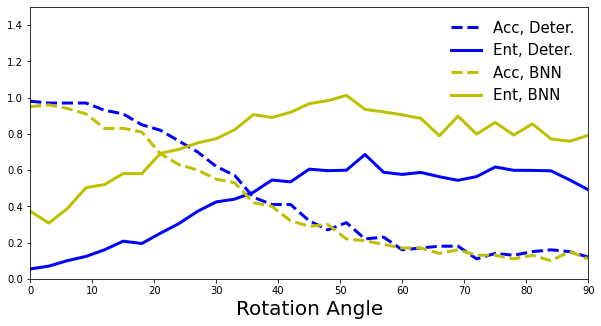

In [ ]:
# generate plot 
fig, ax = plt.subplots(figsize=(10, 5))
plt.xlim([0, 90])
plt.ylim([0, 1.5])
plt.xlabel("Rotation Angle", fontsize=20)

# plot deterministic results
ax.plot(rotation_angles, [accuracy(y_test[:n_test_images], p.argmax(axis=1)) for p in deter_pred_means], 'b--', linewidth=3, label="Acc, Deter.");
ax.plot(rotation_angles, [np.mean(entropy(p.detach().numpy())) for p in deter_pred_means], 'b-', linewidth=3, label="Ent, Deter.");

# plot Ensemble results
ax.plot(rotation_angles, [accuracy(y_test[:n_test_images], p.argmax(axis=1)) for p in bnn_pred_means], 'y--', linewidth=3, label="Acc, BNN")
ax.plot(rotation_angles, [np.mean(entropy(p.detach().numpy())) for p in bnn_pred_means], 'y-', linewidth=3, label="Ent, BNN")

plt.legend(loc=1, fontsize=15, frameon=False);

### Show entropies for all four models.  

Which is the best at detecting the distribution shift?

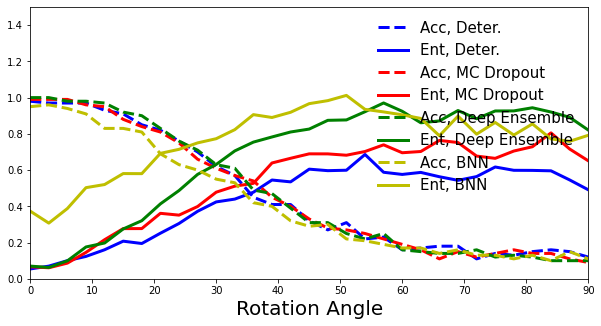

In [ ]:
# generate plot 
fig, ax = plt.subplots(figsize=(10, 5))
plt.xlim([0, 90])
plt.ylim([0, 1.5])
plt.xlabel("Rotation Angle", fontsize=20)

# plot deterministic results
ax.plot(rotation_angles, [accuracy(y_test[:n_test_images], p.argmax(axis=1)) for p in deter_pred_means], 'b--', linewidth=3, label="Acc, Deter.");
ax.plot(rotation_angles, [np.mean(entropy(p.detach().numpy())) for p in deter_pred_means], 'b-', linewidth=3, label="Ent, Deter.");

# plot MC dropout results
ax.plot(rotation_angles, [accuracy(y_test[:n_test_images], p.argmax(axis=1)) for p in dropout_pred_means], 'r--', linewidth=3, label="Acc, MC Dropout")
ax.plot(rotation_angles, [np.mean(entropy(p.detach().numpy())) for p in dropout_pred_means], 'r-', linewidth=3, label="Ent, MC Dropout")

# plot Ensemble results
ax.plot(rotation_angles, [accuracy(y_test[:n_test_images], p.argmax(axis=1)) for p in ensemble_pred_means], 'g--', linewidth=3, label="Acc, Deep Ensemble")
ax.plot(rotation_angles, [np.mean(entropy(p.detach().numpy())) for p in ensemble_pred_means], 'g-', linewidth=3, label="Ent, Deep Ensemble")

# plot BNN results
ax.plot(rotation_angles, [accuracy(y_test[:n_test_images], p.argmax(axis=1)) for p in bnn_pred_means], 'y--', linewidth=3, label="Acc, BNN")
ax.plot(rotation_angles, [np.mean(entropy(p.detach().numpy())) for p in bnn_pred_means], 'y-', linewidth=3, label="Ent, BNN")

plt.legend(loc=1, fontsize=15, frameon=False);